In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Robot():
    def __init__(self):
        self.mass =1.5
        self.Iz = 0.5*self.mass*0.2**2
        self.u = 0.0 #2.0
        self.v = 0.0
        self.yawrate =0.0 # 0.2*np.pi/2
        self.x = 0.0
        self.y = 0.0
        self.psi = 0.0
        self.fx = 0.0
        self.fy = 0.0
        self.time =0.0
        self.timestep = 1e-4
        self.sample_period =1e-1
        self.cf =150
        self.z =[]
        
        self.u_ = self.u
        self.v_ = self.v
        self.yawrate_ = self.yawrate
        self.x_ = 0.0#self.x
        self.y_ = 0.0#self.y
        self.psi_ = self.psi
        self.yawrate_offset = 0.001
        self.gyro_std = 1e-4
        self.gps_x_std = 4.0e-2
        self.gps_y_std = 4.0e-2
        self.ax_std = 1.0e-4
        self.ay_std = 1.0e-4
        self.P = np.array([[100,0,0,0,0],[0,100,0,0,0],[0,0,100,0,0],[0,0,0,100,0],[0,0,0,0,100]])
        self.Q = np.array([[self.ax_std**2,0,0],[0,self.ay_std**2,0],[0,0,self.gyro_std**2]])
        self.R = np.array([[self.gps_x_std**2,0],[0,self.gps_y_std**2]])

    def __rk4(self, func, t, h, y, *x):
        '''
        @brief 4次のルンゲ・クッタ法を一回分計算する関数

        @details この関数では時刻は更新されないため、これとは別に時間更新をする必要があります。

        :parame func:導関数
        :parame t:現在時刻を表す変数
        :parame h:刻み幅
        :parame y:出力変数（求めたい値）
        :parame *x:引数の数が可変する事に対応する、その他の必要変数
        :return 1step分の結果を出力
        '''
        k1=h*func(t, y, *x)
        k2=h*func(t+0.5*h, y+0.5*k1, *x)
        k3=h*func(t+0.5*h, y+0.5*k2, *x) 
        k4=h*func(t+h, y+k3, *x)
        y=y+(k1 + 2.0*k2 + 2.0*k3 + k4)/6.0
        return y

    '''
    導関数の書き方
    def func(t, y, *state):
        func:自分で好きな関数名をつけられます
        t:時刻変数(変数の文字はtで無くても良い) 
        y:出力変数(変数の文字はyで無くても良い)
        *state:その他の必要変数(引数の数は可変可能))
    #関数サンプル
    def vdot(t, y, *state):
        s1=state[0]
        s2=state[1]
        return t+y+s1+s2    
    '''

    def __udot(self, t, u, *state):
        v = state[0]
        r = state[1]
        Fx = state[2]
        return r*v + Fx/self.mass
    
    def __vdot(self, t, v, *state):
        u = state[0]
        r = state[1]
        #Fy = self.mass*r*u
        beta = np.arctan2(v, u)
        Fy = - self.cf* beta
        self.fy = Fy
        return -r*u + Fy/self.mass
    
    def __yawratedot(self, t, yawrate, *state):
        N = state[0]
        return N/self.Iz
    
    def __xdot(self, t, x, *state):
        u = state[0]
        v = state[1]
        psi = state[2]
        return u*np.cos(psi) - v*np.sin(psi)
    
    def __ydot(self, t, y, *state):
        u = state[0]
        v = state[1]
        psi = state[2]
        return u*np.sin(psi) + v*np.cos(psi)
    
    def __psidot(self, t, psi, *state):
        yawrate = state[0]
        return yawrate
    
    def ax(self):
        return self.fx/self.mass + np.random.normal(0.0, self.ax_std)
    
    def ay(self):
        return self.fy/self.mass + np.random.normal(0.0, self.ay_std)

    def gyro_z(self):
        return self.yawrate + self.yawrate_offset + np.random.normal(0.0, self.gyro_std)
    
    def gps_x(self):
        return self.x + np.random.normal(0.0, self.gps_x_std)
    
    def gps_y(self):
        return self.y + np.random.normal(0.0, self.gps_y_std)

    def predict(self, *state):
        u = self.u_
        v = self.v_
        yawrate = self.gyro_z()
        x = self.x_
        y = self.y_
        psi = self.psi_
        ax = self.ax()
        ay = self.ay()
        period = self.sample_period

        self.u_ = u + yawrate * v * period + ax*period
        self.v_ = v - yawrate * u * period + ay*period
        self.x_ = x + (u*np.cos(psi)-v*np.sin(psi))*period
        self.y_ = y + (u*np.sin(psi)+v*np.cos(psi))*period
        self.psi_ = psi + yawrate*period

    def EKF(self):
        period = self.sample_period
        u = self.u_
        v = self.v_
        yawrate = self.gyro_z()
        x = self.x_
        y = self.y_
        x_gps = self.gps_x()
        y_gps = self.gps_y()
        psi = self.psi_
        ax = self.ax()
        ay = self.ay()
        P = self.P
        Q = self.Q
        R = self.R
        
        state = np.array([[u],[v],[x],[y],[psi]])
        z = np.array([[x_gps],[y_gps]])
        H = np.array([[0,0,1,0,0],[0,0,0,1,0]])
        G = np.array([[1,0,v],[0,1,-u],[0,0,0],[0,0,0],[0,0,1]])*period
        s = (H.dot(P)).dot(H.T)+ R
        s = np.linalg.inv(s)
        K = (P.dot(H.T)).dot(s)
        state = state + K.dot(z-H.dot(state))
        P = P - (K.dot(H)).dot(P)
        self.u_ = state[0,0]
        self.v_ = state[1,0]
        self.x_ = state[2,0]
        self.y_ = state[3,0]
        self.psi_ = state[4,0]
        self.predict()
        F = np.array([[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1]])+\
            np.array([[0, yawrate, 0,0,0],\
                      [-yawrate, 0,0,0,0],\
                      [np.cos(psi), -np.sin(psi),0,0, -u*np.sin(psi)-v*np.cos(psi)],\
                      [np.sin(psi),  np.cos(psi),0,0, u*np.cos(psi)-v*np.sin(psi)],\
                      [0,0,0,0,0]])*period
        self.P = (F.dot(P)).dot(F.T)+(G.dot(Q)).dot(G.T)
        self.z = z
        #print(self.P)     

    def step(self, Fx, N):
        self.fx = Fx
        u = self.u
        v = self.v
        yawrate = self.yawrate
        x = self.x
        y = self.y
        psi = self.psi
        time = self.time
        timestep = self.timestep
        self.u = self.__rk4(self.__udot, time, timestep, u, v, yawrate, Fx)
        self.v = self.__rk4(self.__vdot, time, timestep, v, u, yawrate)
        self.yawrate = self.__rk4(self.__yawratedot, time, timestep, yawrate, N)
        self.x = self.__rk4(self.__xdot, time, timestep, x, u, v, psi)
        self.y = self.__rk4(self.__ydot, time, timestep, y, u, v, psi)
        self.psi = self.__rk4(self.__psidot, time, timestep, psi, yawrate)
        self.time = time + self.timestep

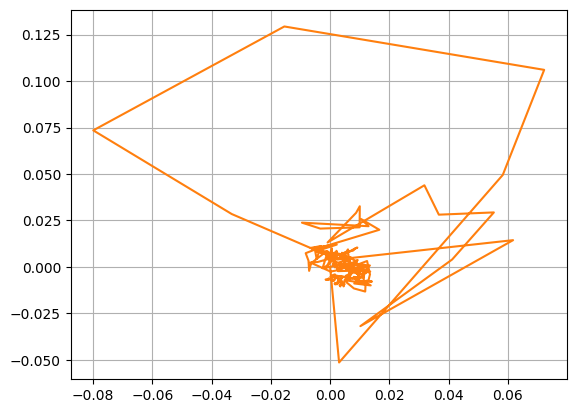

In [2]:
robot = Robot()

T=[]
U=[]
V=[]
Yawrate=[]
X=[]
Y=[]
Psi=[]

Tp=[]
Up=[]
Vp=[]
Yawrate_p=[]
Xp=[]
Yp=[]
Psi_p=[]
Xgps=[]
Ygps=[]


sampletime = 0.0

for _ in range(400000):
    #Save data
    T.append(robot.time)
    U.append(robot.u)
    V.append(robot.v)
    Yawrate.append(robot.yawrate)
    X.append(robot.x)
    Y.append(robot.y)
    Psi.append(robot.psi)
    #Xgps.append(robot.z[0])
    #Ygps.append(robot.z[1])

    #Simulate
    robot.step(0.0, 0.0)
    #EKF
    
    if robot.time > sampletime:
        sampletime += robot.sample_period
        Tp.append(robot.time)
        Up.append(robot.u_)
        Vp.append(robot.v_)
        Yawrate_p.append(robot.yawrate_)
        Xp.append(robot.x_)
        Yp.append(robot.y_)
        Psi_p.append(robot.psi_)
        robot.EKF()
    
#Final data save
T.append(robot.time)
U.append(robot.u)
V.append(robot.v)
Yawrate.append(robot.yawrate)
X.append(robot.x)
Y.append(robot.y)
Psi.append(robot.psi)

plt.plot(X, Y)
plt.plot(Xp, Yp)
plt.grid()
plt.show()


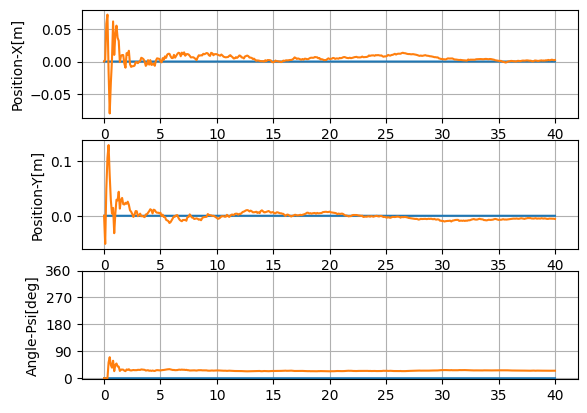

In [3]:
fig =plt.figure()
ax1 = fig.add_subplot(3,1,1)
ax1.plot(T, X)
ax1.plot(Tp, Xp)
ax1.set_ylabel('Position-X[m]')
ax1.grid()
ax2 = fig.add_subplot(3,1,2)
ax2.plot(T, Y)
ax2.plot(Tp, Yp)
ax2.set_ylabel('Position-Y[m]')
ax2.grid()
ax3 = fig.add_subplot(3,1,3)
ax3.plot(T, np.array(Psi)*180/np.pi%360)
ax3.plot(Tp, np.array(Psi_p)*180/np.pi%360)
ax3.set_ylabel('Angle-Psi[deg]')
ax3.set_yticks((0,90,180,270,360))
ax3.grid()
plt.show()

In [4]:
robot.z[0,0]

-0.02978711837090842

In [5]:
robot.z

array([[-0.02978712],
       [-0.04323808]])